EXES: Telluric Correction
================
* **Aim**: Retreive an atmospheric model from the Planetary Spectrum Generator ([PSG](https://psg.gsfc.nasa.gov/)) and use it to remove telluric features. <br />
* **Data**: Level 3 grism data of the Sirius. <br />
* **Tools**: astropy, PSG <br />
* **Instrument**: EXES <br />
* **Documentation**: [EXES data handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/EXES_GO-DataHandbook.pdf)
* **Notebook repository**: https://github.com/SOFIAObservatory/Recipes

Goals
-------
* Inspect EXES data structure.
* Plot EXES spectrum.
* Retrieve atmospheric model from PSG.
* Guassian broadening of model.
* Telluric correction.

Introduction
----------

All EXES level 3 data come with an atmospheric example model or ATRAN model provided for an estimate of the effects of the atmosphere. To do a better job of this, we can retrieve atmospheric models from the PSG and tune different parameters to get something closer to what is found within the target spectrum. 

Ingredients
-----------

Level 3 EXES data of the star Arcturus.

**The data can be directly downloaded [here]()** (to be added soon)

Imports
-----------

In [13]:
import os
import time
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u

%matplotlib inline

In [2]:
# read fits files
hdu = fits.open("../example_data/EXES/F0749_EX_SPE_7500601_EXEELONEXEECHL_MRD_0018.fits")

In [3]:
# print first 15 lines of header
hdu[0].header[0:15]

SIMPLE  =                    T / Written by IDL:  Tue Jul 13 14:54:17 2021      
BITPIX  =                  -64 /Real*8 (double precision)                       
NAXIS   =                    2 /                                                
NAXIS1  =                27044 /                                                
NAXIS2  =                    4 /                                                
ADDTIME =              456.741 / Effective on-source time                       
AIRSPEED=              484.188 / knots, aircraft airspeed das.ic1080...         
ALTI_END=              40997.0 / feet, aircraft altitude end fms.altitude)      
ALTI_STA=              40998.0 / feet, aircraft altitude start das.ic1080_1     
AOR_ID  = '75_0060_1'          / Astronomical Observation Request Identifie     
AOT_ID  = 'UNKNOWN '           / Astronomical Obervation Template               
ASSC_AOR= '75_0060_1'          / All input AOR-IDs                              
BB_TEMP =              273.1

In [4]:
# specify column data
wavenumber = hdu[0].data[0]
flux_unit = u.erg * u.s ** (-1) * (u.cm) ** -2 * u.sr ** (-1)
flux = hdu[0].data[1] * flux_unit
uncertainty = hdu[0].data[2] * flux_unit
atran = hdu[0].data[3]

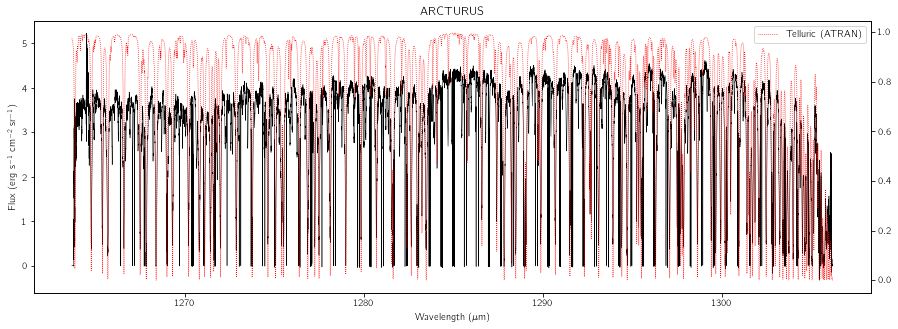

In [5]:
# Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber, flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
ax1.set_xlabel(r"Wavelength ($\mu$m)")
plt.legend()
plt.title("ARCTURUS")
plt.show()

While the average atmospheric (ATRAN) model throughout the night does a good job at estimating the impact of the atmosphere on these observations, we need to do a better job to subtract out these features.  

We will use [Planetary Spectrum Generator (PSG)](https://psg.gsfc.nasa.gov/) API to retreive a more-appropriate model. 

Edit PSG config file
---------------

The PSG model is selected based on parameters specified in a config.txt file. We have provided an example of a config.txt file but can make changes to that file within this notebook. 

In [6]:
# read config file
with open('../example_data/EXES/config.txt') as f:
    config = f.readlines()

In [7]:
# print first lines of config.txt file
config[0:10]

['<OBJECT>Planet\n',
 '<OBJECT-NAME>Earth\n',
 '<OBJECT-DATE>2016/01/24 01:00\n',
 '<OBJECT-DIAMETER>6779\n',
 '<OBJECT-GRAVITY>3.711\n',
 '<OBJECT-GRAVITY-UNIT>g\n',
 '<OBJECT-STAR-DISTANCE>1.6459\n',
 '<OBJECT-STAR-VELOCITY>-1.0679\n',
 '<OBJECT-SOLAR-LONGITUDE>106.4\n',
 '<OBJECT-SOLAR-LATITUDE>25.08\n']

In [8]:
#make changes to config.txt, this can also be done in any txt editor
config[1] = '<OBJECT-NAME>Earth\n',

Download atmospheric model from PSG
-----------------------

In [9]:
# retrieve psg model from PSG
os.popen(
    "curl --data-urlencode file@../example_data/EXES/config.txt https://psg.gsfc.nasa.gov/api.php > ../example_data/EXES/psg_spectrum.txt"
)
# with header
# os.popen("curl -d type=trn -d whdr=n --data-urlencode file@config.txt https://psg.gsfc.nasa.gov/api.php > psg_spectrum.txt")

# wait for download to finish
time.sleep(5)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  945k    0  932k  100 13236   264k   3760  0:00:03  0:00:03 --:--:--  268k


In [10]:
# read psg output file
psg_inp = ascii.read("../example_data/EXES/psg_spectrum.txt", quotechar="#")

# parse into astropy table
psg = Table(psg_inp, names=("wavenumber", "total", "noise", "mars"))

# read first few lines
psg[0:10]

wavenumber,total,noise,mars
float64,float64,float64,float64
1305.997388,3.1828328,6709740.0,3.18283
1305.994776,3.1825703,97743900.0,3.18257
1305.992164,3.1822243,3919610000.0,3.18222
1305.989552,3.1817569,4499100000.0,3.18176
1305.98694,3.1811058,4499010000.0,3.18111
1305.984328,3.1801637,4498880000.0,3.18016
1305.981716,3.1787292,2851980000.0,3.17873
1305.979104,3.1763891,90279800.0,3.17639
1305.976492,3.172172,6314390.0,3.17217


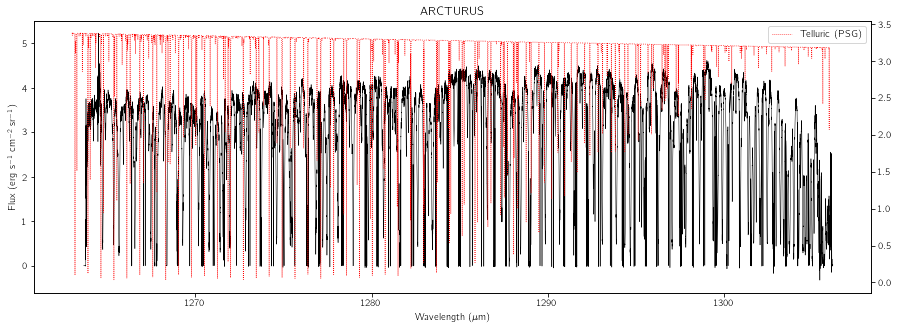

In [12]:
# Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber, flux, lw=0.5, c="k")
ax2.plot(
    psg["wavenumber"], psg["total"], lw=0.75, c="r", linestyle=":", label="Telluric (PSG)"
)
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)")
ax1.set_xlabel(r"Wavelength ($\mu$m)")
plt.legend()
plt.title("ARCTURUS")
plt.show()

The model shows absorption features that are too sharp when compared to the target spectrum. We will need to guassian broadened the PSG model to match the resolution of the data with the resolution of the model.